<h1> Sound Classification - part 4 </h1>

In this part we will use some metrics to compare ML models. Then we will try some feature transformations and select most promissing ones. We will also combine selected transformets and classifiers into pipelines an tune them.

In [1]:
import pandas as pd
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
### let's create our top 5 ml models and gather them in one dictionary for easier manipulation (for ex. inside loops).
ml_classifiers = {}
# to apply scaling where appropriate we will use pipelines
ml_pipes = {}

# as we want to use linear classifiers with scaled features we will build pipeline with 2 steps: scaler and clasifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# create Ridge classifier and add it to our list
from sklearn.linear_model import RidgeClassifier
ml_classifiers['Ridge Classifier'] = RidgeClassifier(random_state=44)
ml_pipes['Ridge Classifier'] = make_pipeline(StandardScaler(), RidgeClassifier(random_state=44))

# create Logistic Regression classifier and add it to our list
from sklearn.linear_model import LogisticRegression
ml_classifiers['Logistic Regression'] = LogisticRegression(random_state=44)
ml_pipes['Logistic Regression'] = make_pipeline(StandardScaler(), LogisticRegression(random_state=44))

# create Multi-Layer Perceptron classifier and add it to our list
from sklearn.neural_network import MLPClassifier
ml_classifiers['Multi-Layer perceptron'] = MLPClassifier(random_state=44)
ml_pipes['Multi-Layer perceptron'] = make_pipeline(StandardScaler(), MLPClassifier(random_state=44))

# create Random Forest classifier and add it to our list
from sklearn.ensemble import RandomForestClassifier
ml_classifiers['Random Forest'] = RandomForestClassifier(n_jobs=-1, n_estimators=500, random_state=44)
ml_pipes['Random Forest'] = RandomForestClassifier(n_jobs=-1, n_estimators=500, random_state=44) # we don't use scaling for RF

# create Support Vector Machines classifier and add it to our list
from sklearn.svm import SVC
ml_classifiers['Support Vector Machines'] = SVC(random_state=44)
ml_pipes['Support Vector Machines'] = make_pipeline(StandardScaler(), SVC(random_state=44))

# print(ml_classifiers)
# print(ml_pipes)

In [3]:
## Loading saved X (features) and Y (labels) from files ()
# mfcc features from part 1
with open('part1_X.pickle', 'rb') as f:
            X_mfcc = pickle.load(f)

# other features from part 3
with open('part3_X.pickle', 'rb') as f:
            X = pickle.load(f)
with open('part3_Y.pickle', 'rb') as f:
            Y = pickle.load(f)

# getting all features together
X_all = pd.concat([X, X_mfcc], axis=1)

# read metadata writen to file in part 1
with open('part1_df.pickle', 'rb') as f:
            df = pickle.load(f)

Spliting data to train and test sets according to predefined folds.

In [4]:
# split data for train and test datasets
train_X = X_all.loc[df['fold']<10]
test_X = X_all.loc[df['fold']==10]
train_Y = Y.loc[df['fold']<10]
test_Y = Y.loc[df['fold']==10]

The basic metric in classification task is accuracy. We are using it from first part to compare our ML models. It tells us how many samples is classified correctly. The more samples classified correctly the better. We can calculate this metrics for our models using <i>accuracy_score</i> function from <i>sklearn.metrics</i> library or directly in our models using <i>score</i> function.

In [5]:
from sklearn.metrics import accuracy_score

scores = {}
for name, clf in ml_pipes.items():
    clf.fit(train_X, train_Y)
    y_pred = clf.predict(test_X)
    score = 100*accuracy_score(test_Y, y_pred)
    scores[name]=score
    print(name ,f"accuracy score (fractional): {score: .2f} %")

Ridge Classifier accuracy score (fractional):  69.18 %
Logistic Regression accuracy score (fractional):  70.13 %
Multi-Layer perceptron accuracy score (fractional):  74.43 %
Random Forest accuracy score (fractional):  75.15 %
Support Vector Machines accuracy score (fractional):  77.66 %


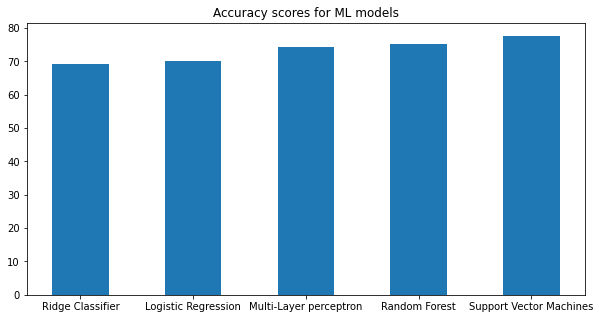

In [6]:
plt.figure(figsize=(10,5))
plt.bar(x=scores.keys(), height=scores.values(), width=0.5)
plt.title("Accuracy scores for ML models");

Here we will define groups of indexes for cross validation. One version for cross validation using 9 folds but with 3 splits - 3 olds per split. Second version for cross validation using 10 folds (and 10 splits).

In [7]:
# defining training and testing sets 90% / 10%
train_df = df.loc[df['fold']!=10].copy()

# generating 3 groups for cross validation
cv_groups = []
for i in range(1, 10, 3):
    a , b, c = i, i+1, i+2
    temp_train_X = train_X.loc[(train_df['fold']!=a) & (train_df['fold']!=b) & (train_df['fold']!=c)].copy()
    temp_test_X = train_X.loc[(train_df['fold']==a) | (train_df['fold']==b) | (train_df['fold']==c)].copy()
    cv_groups.append((temp_train_X.index, temp_test_X.index))
    
# defining 10 groups for corss validation
cv_groups_10_fold = []
for i in range(1, 11):
    temp_train_X = X_all.loc[df['fold']!=i]
    temp_test_X = X_all.loc[df['fold']==i]
    cv_groups_10_fold.append((temp_train_X.index, temp_test_X.index))

In [8]:
from sklearn.model_selection import cross_val_score
scores_table = pd.DataFrame()

for name, clf in ml_pipes.items():
    clf = ml_pipes[name]
    scores = cross_val_score(clf, X_all, Y, cv=cv_groups, n_jobs=-1)
    score = np.mean(scores)
    print(name, '9 folds 3 splits score:', score)
    scores_table.loc[name + ' default','cv_9fold_3splits'] = score
    
    scores = cross_val_score(clf, X_all, Y, cv=cv_groups_10_fold, n_jobs=-1)
    score = np.mean(scores)
    print(name, '10 folds score:', score)
    scores_table.loc[name + ' default','cv_10fold'] = score

Ridge Classifier 9 folds 3 splits score: 0.6352461983236206
Ridge Classifier 10 folds score: 0.6702952004307678
Logistic Regression 9 folds 3 splits score: 0.634696848119377
Logistic Regression 10 folds score: 0.6739810428384552
Multi-Layer perceptron 9 folds 3 splits score: 0.6540507088557225
Multi-Layer perceptron 10 folds score: 0.6942752615453903
Random Forest 9 folds 3 splits score: 0.6605979509199423
Random Forest 10 folds score: 0.6996477682868633
Support Vector Machines 9 folds 3 splits score: 0.661184544382206
Support Vector Machines 10 folds score: 0.7076776015781003


In [9]:
scores_table

,cv_9fold_3splits,cv_10fold
Ridge Classifier default,0.635246,0.670295
Logistic Regression default,0.634697,0.673981
Multi-Layer perceptron default,0.654051,0.694275
Random Forest default,0.660598,0.699648
Support Vector Machines default,0.661185,0.707678


We have general comparison of our models. We will try to ensamble it in next part. In this part we want to make each of them perfom as good as possible. We need to decide what can be done to improve each of our model.</br>

Now we want to check is if our models aren't suffering from high bias or high variance. To check that we can create and plot learning curve for this model. Learning curve shows how metrics computed for training set and for validating set are changing when we increase the number of training samples. We will start with fold1 as training set, then we will add fold2, then fold3 and so on up to fold8. We will use fold9 as validating set (we don't want our model to look fold10). We will plot accuracy vs number of folds of training data.

In [10]:
# we need to exclude validating set from training set
train_X = X_all.loc[df['fold']<9]
val_X = X_all.loc[df['fold']==9]
train_Y = Y.loc[df['fold']<9]
val_Y = Y.loc[df['fold']==9]

def plot_learning_curve(clf, train_X, val_X, train_Y, val_Y):
    train_score = []
    val_score = []
    x = []

    for i in range(1,9):
        temp_train_X = train_X.loc[df['fold']<=i]
        temp_train_Y = train_Y.loc[df['fold']<=i]
        clf.fit(temp_train_X, temp_train_Y)
        train_score.append(clf.score(temp_train_X, temp_train_Y))
        val_score.append(clf.score(val_X, val_Y))
        x.append(i)

    plt.plot(x, train_score, label="training set score")
    plt.plot(x, val_score, label="validating set score")
    plt.legend();

SVM

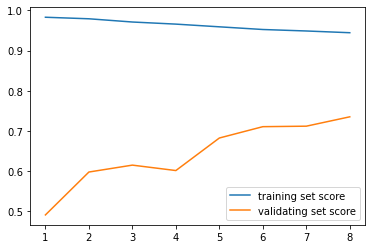

In [11]:
plot_learning_curve(ml_pipes['Support Vector Machines'], train_X, val_X, train_Y, val_Y)

The blue curve represents training set accuracy score and the orange one represents validating set accuracy score.</br>
The perfect situation which is the goal is when both values are veery high (near 1).</br>
When train score is high and validate score is low we have high variance (overfitting) - we can see it on the plot.</br>
When both curves are near each other and they are low then we have high bias - the model is not complex enough to get good results.</br>
Very important thing is how the curves changes when we add training data. In our curves we can observe that train curve is decreasing slowly and the validate curve is increasing so we can expect that gathering more training data could improve model performance.</br>

Random Forest

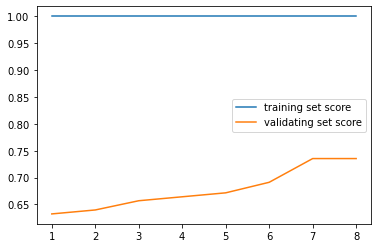

In [12]:
plot_learning_curve(ml_pipes['Random Forest'], train_X, val_X, train_Y, val_Y)

Multi-Layer perceptron

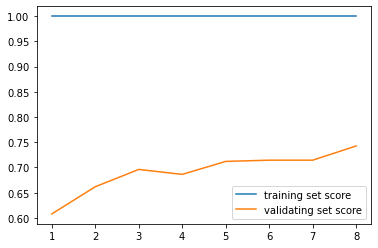

In [13]:
plot_learning_curve(ml_pipes['Multi-Layer perceptron'], train_X, val_X, train_Y, val_Y)

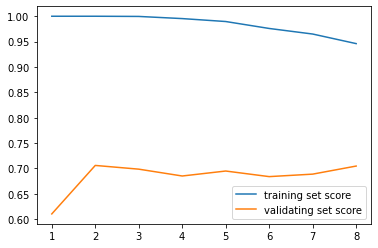

In [14]:
plot_learning_curve(ml_pipes['Logistic Regression'], train_X, val_X, train_Y, val_Y)

Ridge Classifier

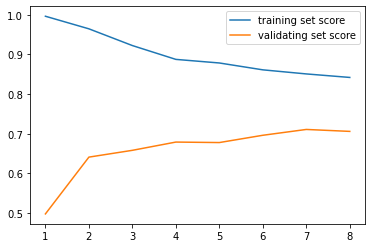

In [15]:
plot_learning_curve(ml_pipes['Ridge Classifier'], train_X, val_X, train_Y, val_Y)

On the first 3 curves we can see overfitting. We will check during final models tunnig if regularization will help.</br>
On the learning curve for logistic regression model we can observe that when increasing training data validating score don't increase but training score starts to deacrease suddenly. It can be some problem in the data - outliers, correlated features. We need to check this.</br>
On the curve for ridge classifier we can see high bias. The model is to simple to find patterns direcly from given data. We can try adding some new features.

Now let's investigate what kind of errors our model does. Let's display confusion matrix.

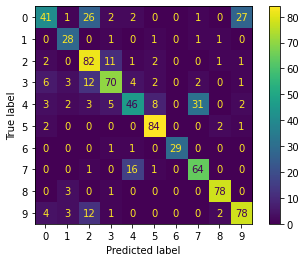

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(clf, train_X, train_Y, test_X, test_Y):
    clf.fit(train_X, train_Y)
    y_pred = clf.predict(test_X)
    cm = confusion_matrix(test_Y, y_pred)
#     I = np.eye(10)
#     matrix_to_sub = I*cm
#     new_cm = cm - matrix_to_sub
#     disp = ConfusionMatrixDisplay(confusion_matrix=new_cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show();

plot_confusion_matrix(ml_pipes['Support Vector Machines'], train_X, train_Y, val_X, val_Y)

In [17]:
df.groupby('classID')['class'].unique()

classID
0     [air_conditioner]
1            [car_horn]
2    [children_playing]
3            [dog_bark]
4            [drilling]
5       [engine_idling]
6            [gun_shot]
7          [jackhammer]
8               [siren]
9        [street_music]
Name: class, dtype: object

Looking at the confusion matrix we can see that our model quite often classifies air 'conditioner' as 'children playing' or 'street music'. It also confuses 'dog bark' with 'children playing' as well as 'drilling' with 'jackhammer'.</br>
Let's plot and display learning curve

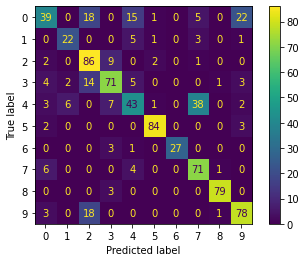

In [18]:
plot_confusion_matrix(ml_pipes['Random Forest'], train_X, train_Y, val_X, val_Y)

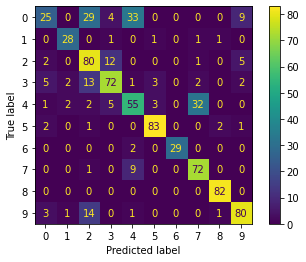

In [19]:
plot_confusion_matrix(ml_pipes['Multi-Layer perceptron'], train_X, train_Y, val_X, val_Y)

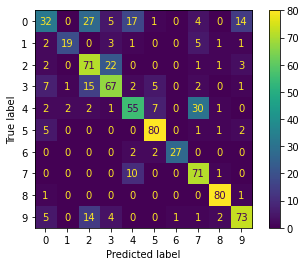

In [20]:
plot_confusion_matrix(ml_pipes['Logistic Regression'], train_X, train_Y, val_X, val_Y)

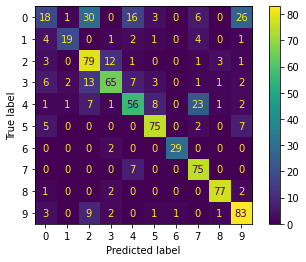

In [21]:
plot_confusion_matrix(ml_pipes['Ridge Classifier'], train_X, train_Y, val_X, val_Y)

All models confuses are of the same kind. Can we expect that ensamling those models can potentialy improve overoll system accuracy? We need to verify if the errors are made on the same sammples. We need to compare models predictions directly. We can use accuracy_score function for that.

In [22]:
# let's save models predictions into variables
ml_pipes['Ridge Classifier'].fit(train_X, train_Y)
ridge_preds = ml_pipes['Ridge Classifier'].predict(val_X)

ml_pipes['Logistic Regression'].fit(train_X, train_Y)
logistic_preds = ml_pipes['Logistic Regression'].predict(val_X)

ml_pipes['Multi-Layer perceptron'].fit(train_X, train_Y)
mlp_preds = ml_pipes['Multi-Layer perceptron'].predict(val_X)

ml_pipes['Random Forest'].fit(train_X, train_Y)
rf_preds = ml_pipes['Random Forest'].predict(val_X)

ml_pipes['Support Vector Machines'].fit(train_X, train_Y)
svc_preds = ml_pipes['Support Vector Machines'].predict(val_X)

In [23]:
print("Ridge vs Logistic Regression: ", accuracy_score(ridge_preds, logistic_preds))
print("Ridge vs Multi-Layer perceptron: ", accuracy_score(ridge_preds, mlp_preds))
print("Ridge vs Random Forest: ", accuracy_score(ridge_preds, rf_preds))
print("Ridge vs SVM: ", accuracy_score(ridge_preds, svc_preds))
print("Logistic Regression vs Multi-Layer perceptron: ", accuracy_score(logistic_preds, mlp_preds))
print("Logistic Regression vs Random Forest: ", accuracy_score(logistic_preds, rf_preds))
print("Logistic Regression vs SVM: ", accuracy_score(logistic_preds, svc_preds))
print("Multi-Layer perceptron vs Random Forest: ", accuracy_score(mlp_preds, rf_preds))
print("Multi-Layer perceptron vs SVM: ", accuracy_score(mlp_preds, svc_preds))
print("Random Forest vs SVM: ", accuracy_score(rf_preds, svc_preds))

Ridge vs Logistic Regression:  0.8063725490196079
Ridge vs Multi-Layer perceptron:  0.803921568627451
Ridge vs Random Forest:  0.7745098039215687
Ridge vs SVM:  0.7879901960784313
Logistic Regression vs Multi-Layer perceptron:  0.8284313725490197
Logistic Regression vs Random Forest:  0.7708333333333334
Logistic Regression vs SVM:  0.7892156862745098
Multi-Layer perceptron vs Random Forest:  0.8014705882352942
Multi-Layer perceptron vs SVM:  0.8455882352941176
Random Forest vs SVM:  0.8406862745098039


We can see that the predictions aren't the same so we can expect that combining them into one system can give better results then those from individual models.

There is one more interesting function in scikit-learn classification_report. It returns metrics such as precision, recall and f1-score for individual classes.

In [24]:
from sklearn.metrics import classification_report

print('Classification report for ridge classifier:\n')
print(classification_report(val_Y, ridge_preds))

Classification report for ridge classifier:

                  precision    recall  f1-score   support

 air_conditioner       0.44      0.18      0.26       100
        car_horn       0.83      0.59      0.69        32
children_playing       0.57      0.79      0.66       100
        dog_bark       0.76      0.65      0.70       100
        drilling       0.63      0.56      0.59       100
   engine_idling       0.82      0.84      0.83        89
        gun_shot       0.97      0.94      0.95        31
      jackhammer       0.67      0.91      0.77        82
           siren       0.93      0.94      0.93        82
    street_music       0.67      0.83      0.74       100

        accuracy                           0.71       816
       macro avg       0.73      0.72      0.71       816
    weighted avg       0.70      0.71      0.69       816



In [25]:
print('Classification report for logistic regression:\n')
print(classification_report(val_Y, logistic_preds))

Classification report for logistic regression:

                  precision    recall  f1-score   support

 air_conditioner       0.57      0.32      0.41       100
        car_horn       0.86      0.59      0.70        32
children_playing       0.55      0.71      0.62       100
        dog_bark       0.66      0.67      0.66       100
        drilling       0.63      0.55      0.59       100
   engine_idling       0.84      0.90      0.87        89
        gun_shot       0.96      0.87      0.92        31
      jackhammer       0.62      0.87      0.72        82
           siren       0.92      0.98      0.95        82
    street_music       0.77      0.73      0.75       100

        accuracy                           0.70       816
       macro avg       0.74      0.72      0.72       816
    weighted avg       0.71      0.70      0.70       816



In [26]:
print('Classification report for MLP:\n')
print(classification_report(val_Y, mlp_preds))

Classification report for MLP:

                  precision    recall  f1-score   support

 air_conditioner       0.66      0.25      0.36       100
        car_horn       0.85      0.88      0.86        32
children_playing       0.57      0.80      0.67       100
        dog_bark       0.77      0.72      0.74       100
        drilling       0.54      0.55      0.55       100
   engine_idling       0.92      0.93      0.93        89
        gun_shot       1.00      0.94      0.97        31
      jackhammer       0.67      0.88      0.76        82
           siren       0.95      1.00      0.98        82
    street_music       0.82      0.80      0.81       100

        accuracy                           0.74       816
       macro avg       0.78      0.77      0.76       816
    weighted avg       0.75      0.74      0.73       816



In [27]:
print('Classification report for random forest:\n')
print(classification_report(val_Y, rf_preds))

Classification report for random forest:

                  precision    recall  f1-score   support

 air_conditioner       0.66      0.39      0.49       100
        car_horn       0.73      0.69      0.71        32
children_playing       0.63      0.86      0.73       100
        dog_bark       0.76      0.71      0.74       100
        drilling       0.59      0.43      0.50       100
   engine_idling       0.94      0.94      0.94        89
        gun_shot       1.00      0.87      0.93        31
      jackhammer       0.60      0.87      0.71        82
           siren       0.96      0.96      0.96        82
    street_music       0.72      0.78      0.75       100

        accuracy                           0.74       816
       macro avg       0.76      0.75      0.75       816
    weighted avg       0.74      0.74      0.73       816



In [28]:
print('Classification report for support vector machines:\n')
print(classification_report(val_Y, svc_preds))

Classification report for support vector machines:

                  precision    recall  f1-score   support

 air_conditioner       0.71      0.41      0.52       100
        car_horn       0.70      0.88      0.78        32
children_playing       0.60      0.82      0.69       100
        dog_bark       0.76      0.70      0.73       100
        drilling       0.66      0.46      0.54       100
   engine_idling       0.86      0.94      0.90        89
        gun_shot       1.00      0.94      0.97        31
      jackhammer       0.65      0.78      0.71        82
           siren       0.93      0.95      0.94        82
    street_music       0.71      0.78      0.74       100

        accuracy                           0.74       816
       macro avg       0.76      0.77      0.75       816
    weighted avg       0.74      0.74      0.73       816



Looking at this report, especially on f1-score we can tell that we can safely farther use accuracy score. The classes that has less samples then the other get high f1-scores, even better then the others.

Let's get back to our models and our data.

<h1> Columns with little or no information</h1>

We shoud identify features with the same values in most samples and consider droping those columns.

In [29]:
# get features names
columns = X_all.columns
num_of_samples = len(X_all)

# create empty list, columns that have to be dropped will be added
cols_to_drop = []

for col in columns:
    temp = X_all[col].value_counts().sort_values(ascending=False)
    if list(temp)[0]/num_of_samples > 0.9: # if over 90 % of samples have the same value we want to drop it
        cols_to_drop.append(col)
        
# show selected columns        
cols_to_drop

['delta_ae_median']

Let's take a look at 'delata_ae_median'.

In [30]:
X_all[cols_to_drop[0]].value_counts().sort_values(ascending=False)/len(X_all)*100

 0.000000    98.098946
-0.008606     0.022904
-0.023376     0.022904
-0.011505     0.011452
-0.012527     0.011452
-0.000015     0.011452
-0.001068     0.011452
-0.024048     0.011452
-0.006149     0.011452
-0.005051     0.011452
-0.013870     0.011452
-0.026184     0.011452
-0.009369     0.011452
-0.005966     0.011452
-0.012421     0.011452
-0.011078     0.011452
-0.011124     0.011452
-0.016449     0.011452
-0.005875     0.011452
-0.008118     0.011452
-0.009384     0.011452
-0.021866     0.011452
-0.008133     0.011452
-0.015549     0.011452
-0.014877     0.011452
-0.020477     0.011452
-0.014206     0.011452
-0.039841     0.011452
-0.013489     0.011452
-0.006790     0.011452
-0.009720     0.011452
-0.007263     0.011452
-0.005219     0.011452
-0.022430     0.011452
-0.016602     0.011452
-0.023041     0.011452
-0.019501     0.011452
-0.017822     0.011452
-0.032578     0.011452
-0.021179     0.011452
-0.021729     0.011452
-0.025925     0.011452
-0.003952     0.011452
-0.019806  

Over 98% of 0's. We will build a transformer which will allow us to drop columns and we could use it in pipeline for grid search. As an argument we will pass the treshold for percentage of most frequent value in column.

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin
# The CorrelatedFeaturesRemover class inherits from the sklearn.base classes 
# (BaseEstimator, TransformerMixin). This makes it compatible with 
# scikit-learn’s Pipelines

class DropColumns(BaseEstimator, TransformerMixin):
    # initializer 
    def __init__(self, percentage_treshold):
        self.percentage_treshold = percentage_treshold
        
    def fit(self, X, y = None):
        self.cols_to_drop_ = []
        X_ = X.copy()
        num_of_samples = len(X_)

        for col in X_.columns:
            temp = X_[col].value_counts().sort_values(ascending=False)
            if (list(temp)[0]/num_of_samples) > self.percentage_treshold[0]:
                self.cols_to_drop_.append(col)
                
        return self
    
    def transform(self, X, y = None):
        X2 = X.copy()
        X2.drop(self.cols_to_drop_, axis=1, inplace=True)
        return X2

Let's test it

In [32]:
temp_X = X_all.iloc[:,0:3]
temp_X.columns, temp_X.shape

(Index(['rms_mean', 'rms_median', 'rms_min'], dtype='object'), (8732, 3))

In [33]:
dc = DropColumns([0.1])
temp_X2 = dc.fit_transform(temp_X)
temp_X2.columns, temp_X2.shape

(Index(['rms_mean'], dtype='object'), (8732, 1))

<h1>Outliers</h1>

Let's get back to our models and try to improve them.</br>
We can start with indentifying the outliers and checking if they affect on our models accuracy. We will look for values that are  much bigger or much smaller than average. We will investigate standardized features where avarege value is about 0 and standard deviation equals 1. We can then direcly apply given treshold and in this way identificate outliers.

In [34]:
scaler = StandardScaler()
train_X_scaled = pd.DataFrame(scaler.fit_transform(train_X), columns=train_X.columns, index=train_X.index)
train_X_scaled.describe()

,rms_mean,rms_median,rms_min,rms_max,rms_std,rms_skew,rms_kurtosis,delta_rms_mean,delta_rms_median,delta_rms_min,delta_rms_max,delta_rms_std,delta_rms_skew,delta_rms_kurtosis,delta2_rms_mean,delta2_rms_median,delta2_rms_min,delta2_rms_max,delta2_rms_std,delta2_rms_skew,delta2_rms_kurtosis,ae_mean,ae_median,ae_min,ae_max,ae_std,ae_skew,ae_kurtosis,delta_ae_mean,delta_ae_median,delta_ae_min,delta_ae_max,delta_ae_std,delta_ae_skew,delta_ae_kurtosis,delta2_ae_mean,delta2_ae_median,delta2_ae_min,delta2_ae_max,delta2_ae_std,delta2_ae_skew,delta2_ae_kurtosis,zcr_mean,zcr_median,zcr_min,zcr_max,zcr_std,zcr_skew,zcr_kurtosis,delta_zcr_mean,delta_zcr_median,delta_zcr_min,delta_zcr_max,delta_zcr_std,delta_zcr_skew,delta_zcr_kurtosis,delta2_zcr_mean,delta2_zcr_median,delta2_zcr_min,delta2_zcr_max,delta2_zcr_std,delta2_zcr_skew,delta2_zcr_kurtosis,spec_centr_mean,spec_centr_median,spec_centr_min,spec_centr_max,spec_centr_std,spec_centr_skew,spec_centr_kurtosis,delta_spec_centr_mean,delta_spec_centr_median,delta_spec_centr_min,delta_spec_centr_max,delta_spec_centr_std,delta_spec_centr_skew,delta_spec_centr_kurtosis,delta2_spec_centr_mean,delta2_spec_centr_median,delta2_spec_centr_min,delta2_spec_centr_max,delta2_spec_centr_std,delta2_spec_centr_skew,delta2_spec_centr_kurtosis,spec_flat_mean,spec_flat_median,spec_flat_min,spec_flat_max,spec_flat_std,spec_flat_skew,spec_flat_kurtosis,delta_spec_flat_mean,delta_spec_flat_median,delta_spec_flat_min,delta_spec_flat_max,delta_spec_flat_std,delta_spec_flat_skew,delta_spec_flat_kurtosis,delta2_spec_flat_mean,delta2_spec_flat_median,delta2_spec_flat_min,delta2_spec_flat_max,delta2_spec_flat_std,delta2_spec_flat_skew,delta2_spec_flat_kurtosis,mfcc_1_mean,mfcc_1_var,mfcc_1_median,mfcc_1_min,mfcc_1_max,mfcc_1_skew,mfcc_1_kurtosis,delta_mfcc_1_mean,delta_mfcc_1_var,delta2_mfcc_1_mean,delta2_mfcc_1_var,mfcc_2_mean,mfcc_2_var,mfcc_2_median,mfcc_2_min,mfcc_2_max,mfcc_2_skew,mfcc_2_kurtosis,delta_mfcc_2_mean,delta_mfcc_2_var,delta2_mfcc_2_mean,delta2_mfcc_2_var,mfcc_3_mean,mfcc_3_var,mfcc_3_median,mfcc_3_min,mfcc_3_max,mfcc_3_skew,mfcc_3_kurtosis,delta_mfcc_3_mean,delta_mfcc_3_var,delta2_mfcc_3_mean,delta2_mfcc_3_var,mfcc_4_mean,mfcc_4_var,mfcc_4_median,mfcc_4_min,mfcc_4_max,mfcc_4_skew,mfcc_4_kurtosis,delta_mfcc_4_mean,delta_mfcc_4_var,delta2_mfcc_4_mean,delta2_mfcc_4_var,mfcc_5_mean,mfcc_5_var,mfcc_5_median,mfcc_5_min,mfcc_5_max,mfcc_5_skew,mfcc_5_kurtosis,delta_mfcc_5_mean,delta_mfcc_5_var,delta2_mfcc_5_mean,delta2_mfcc_5_var,mfcc_6_mean,mfcc_6_var,mfcc_6_median,mfcc_6_min,mfcc_6_max,mfcc_6_skew,mfcc_6_kurtosis,delta_mfcc_6_mean,delta_mfcc_6_var,delta2_mfcc_6_mean,delta2_mfcc_6_var,mfcc_7_mean,mfcc_7_var,mfcc_7_median,mfcc_7_min,mfcc_7_max,mfcc_7_skew,mfcc_7_kurtosis,delta_mfcc_7_mean,delta_mfcc_7_var,delta2_mfcc_7_mean,delta2_mfcc_7_var,mfcc_8_mean,mfcc_8_var,mfcc_8_median,mfcc_8_min,mfcc_8_max,mfcc_8_skew,mfcc_8_kurtosis,delta_mfcc_8_mean,delta_mfcc_8_var,delta2_mfcc_8_mean,delta2_mfcc_8_var,mfcc_9_mean,mfcc_9_var,mfcc_9_median,mfcc_9_min,mfcc_9_max,mfcc_9_skew,mfcc_9_kurtosis,delta_mfcc_9_mean,delta_mfcc_9_var,delta2_mfcc_9_mean,delta2_mfcc_9_var,mfcc_10_mean,mfcc_10_var,mfcc_10_median,mfcc_10_min,mfcc_10_max,mfcc_10_skew,mfcc_10_kurtosis,delta_mfcc_10_mean,delta_mfcc_10_var,delta2_mfcc_10_mean,delta2_mfcc_10_var,mfcc_11_mean,mfcc_11_var,mfcc_11_median,mfcc_11_min,mfcc_11_max,mfcc_11_skew,mfcc_11_kurtosis,delta_mfcc_11_mean,delta_mfcc_11_var,delta2_mfcc_11_mean,delta2_mfcc_11_var,mfcc_12_mean,mfcc_12_var,mfcc_12_median,mfcc_12_min,mfcc_12_max,mfcc_12_skew,mfcc_12_kurtosis,delta_mfcc_12_mean,delta_mfcc_12_var,delta2_mfcc_12_mean,delta2_mfcc_12_var,mfcc_13_mean,mfcc_13_var,mfcc_13_median,mfcc_13_min,mfcc_13_max,mfcc_13_skew,mfcc_13_kurtosis,delta_mfcc_13_mean,delta_mfcc_13_var,delta2_mfcc_13_mean,delta2_mfcc_13_var,mfcc_14_mean,mfcc_14_var,mfcc_14_median,mfcc_14_min,mfcc_14_max,mfcc_14_skew,mfcc_14_kurtosis,delta_mfcc_14_mean,delta_mfcc_14_var,delta2_mfcc_14_mean,delta2_mfcc_14_var,mfcc_15_mean,mfcc_15_

In [35]:
def get_outliers(df, treshold):
    X = df.copy()
    indexes = set() # 
    cols = X.columns
    for col in cols:
        temp_X = X.loc[(X[col]>treshold) | (X[col]<-treshold)]
        indexes.update(set(temp_X.index))
        
    return list(indexes)

In [36]:
outliers50 = get_outliers(train_X_scaled, 50)
outliers51 = get_outliers(train_X_scaled, 51)
len(outliers50), len(outliers51)

(1, 0)

In [37]:
train_X_cleaned = train_X.drop(outliers50, axis=0, inplace=False)
train_Y_cleaned = train_Y.loc[train_X_cleaned.index]
train_X.shape, train_X_cleaned.shape

((7079, 380), (7078, 380))

Let's write a function that will remove outliers which values reach given treshold

In [38]:
def remove_outliers(X, y, treshold):
    X2 = X.copy()
    outliers = get_outliers(X2, treshold)
    X_cleaned = X2.drop(outliers, axis=0, inplace=False)
    y_cleaned = y.loc[X_cleaned.index]
    return X_cleaned, y_cleaned

We will test a range of tresholds and save a version with best validating score for each classifier.

treshold:  20 score:  71.20098039215686


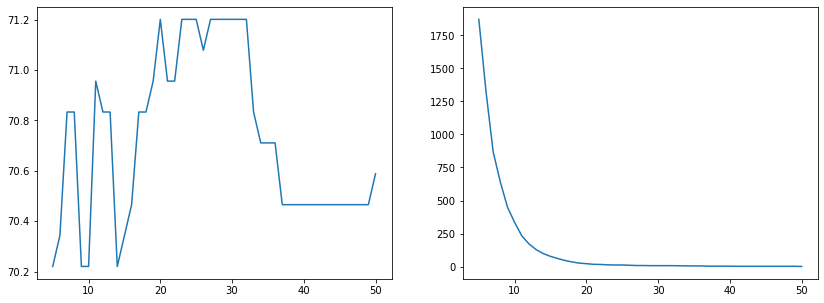

In [39]:
def plot_accuracy_vs_outliers_treshold(clf):
    best_score = 0
    best_treshold = 51
    scores=[] # to keep scores for different treshold
    outliers_num=[] # to keep number of identified outliers for different treshold

    tresholds = range(5,51)
    
    scaler = StandardScaler()
    train_X_scaled = pd.DataFrame(scaler.fit_transform(train_X), columns=train_X.columns, index=train_X.index)
    
    for tres in tresholds:
        outliers = get_outliers(train_X_scaled, tres)
        outliers_num.append(len(outliers))
        train_X_cleaned = train_X.drop(outliers, axis=0, inplace=False)
        train_Y_cleaned = train_Y.loc[train_X_cleaned.index]

        clf.fit(train_X_cleaned, train_Y_cleaned)
        y_pred = clf.predict(val_X)
        score = 100*accuracy_score(val_Y, y_pred)
        scores.append(score)
        if score>best_score:
            best_score=score
            best_treshold=tres

    print('treshold: ', best_treshold, 'score: ', best_score)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(tresholds, scores);
    ax2.plot(tresholds, outliers_num);
    
plot_accuracy_vs_outliers_treshold(ml_pipes['Ridge Classifier'])

Shell we consider removing outliers? Looking at those curves when treshold is high (about 40 std's) we get worse results then when we do not remove outliers at all. Getting better results for tresholds between 20 and 30 can be effect of finding some local extreme.

treshold:  12 score:  70.95588235294117


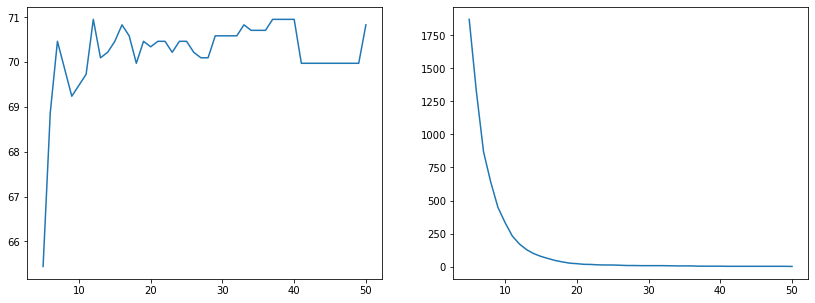

In [40]:
plot_accuracy_vs_outliers_treshold(ml_pipes['Logistic Regression'])

Not improved much.

treshold:  19 score:  74.63235294117648


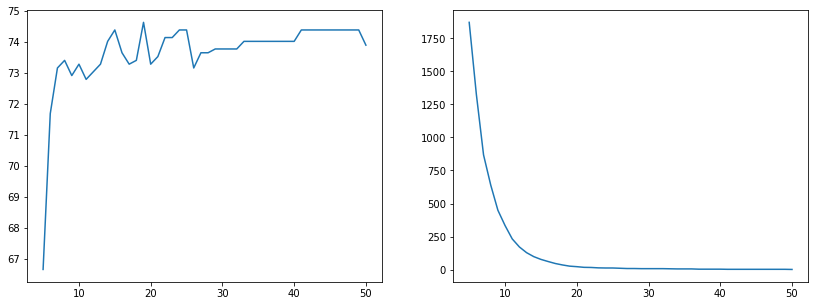

In [41]:
plot_accuracy_vs_outliers_treshold(ml_pipes['Multi-Layer perceptron'])

treshold:  50 score:  74.26470588235294


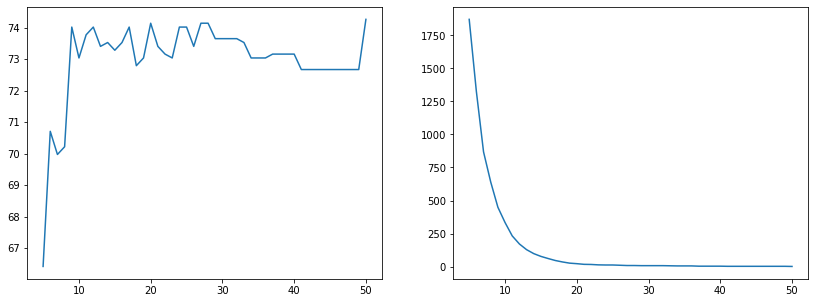

In [42]:
plot_accuracy_vs_outliers_treshold(ml_pipes['Random Forest'])

treshold:  27 score:  73.65196078431373


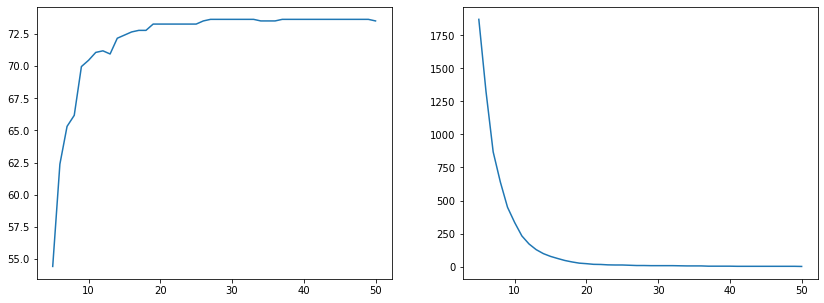

In [43]:
plot_accuracy_vs_outliers_treshold(ml_pipes['Support Vector Machines'])

It is not so obvious that removing outliers could improve our models performance. What is more, it would be hard to implement in standard scikit-learn pipeline to find the best treshold using GridSearchCV. Let's try to replace outliers - overwrite their value with values equal to treshold.

In [44]:
def replace_outliers(X, factor):
    X2 = X.copy()
    for col in X2.columns:
        col_mean = np.mean(X2[col])
        col_std = np.std(X2[col])
        col_tres = col_std * factor
        X2[col] = X2[col].apply(lambda x: x if np.abs(x)<col_tres else col_tres*x/np.abs(x))
    return X2

treshold:  7 score:  71.44607843137256


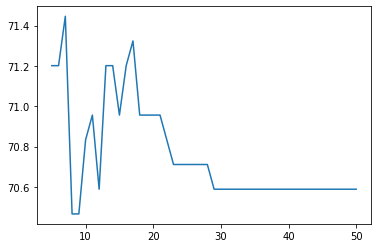

In [45]:
def plot_accuracy_vs_replace_outliers_treshold(clf):
    best_score = 0
    best_treshold = 51
    scores=[]

    tresholds = range(5,51)
    
    for tres in tresholds:
        train_X2 = replace_outliers(train_X, tres)
        clf.fit(train_X2, train_Y)
        y_pred = clf.predict(val_X)
        score = 100*accuracy_score(val_Y, y_pred)
        scores.append(score)
        if score>best_score:
            best_score=score
            best_treshold=tres

    print('treshold: ', best_treshold, 'score: ', best_score)

    plt.plot(tresholds, scores)
    
plot_accuracy_vs_replace_outliers_treshold(ml_pipes['Ridge Classifier'])

treshold:  25 score:  71.32352941176471


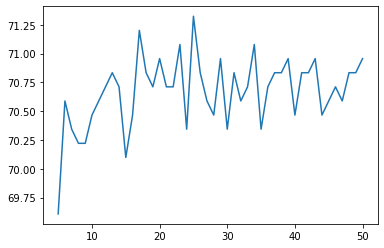

In [46]:
plot_accuracy_vs_replace_outliers_treshold(ml_pipes['Logistic Regression'])

treshold:  22 score:  74.38725490196079


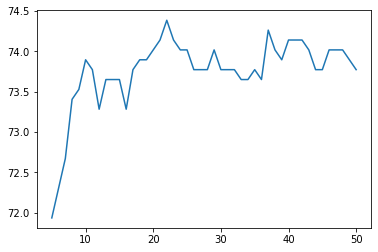

In [47]:
plot_accuracy_vs_replace_outliers_treshold(ml_pipes['Multi-Layer perceptron'])

treshold:  6 score:  74.01960784313727


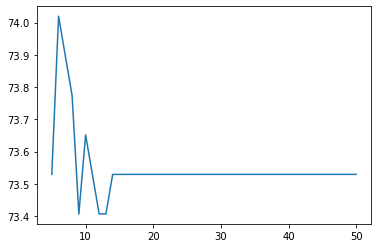

In [48]:
plot_accuracy_vs_replace_outliers_treshold(ml_pipes['Random Forest'])

treshold:  27 score:  73.52941176470588


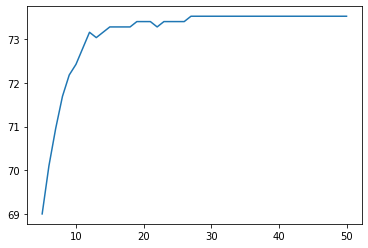

In [49]:
plot_accuracy_vs_replace_outliers_treshold(ml_pipes['Support Vector Machines'])

Let's create our custom transformer for replacing outliers. We will use it in our final pipeline try to find optimum treshold using GridSearchCV.

In [50]:
from sklearn.base import BaseEstimator, TransformerMixin
# The CorrelatedFeaturesRemover class inherits from the sklearn.base classes 
# (BaseEstimator, TransformerMixin). This makes it compatible with 
# scikit-learn’s Pipelines

class ReplaceOutliers(BaseEstimator, TransformerMixin):
    # initializer 
    def __init__(self, factor):
        self.factor = factor
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X2 = X.copy()
        if type(X2)!=type(pd.DataFrame()):
            X2 = pd.DataFrame(X2, columns=['f'+str(i) for i in range(X2.shape[1])])
        for col in X2.columns:
            col_mean = np.mean(X2[col])
            col_std = np.std(X2[col])
            col_tres = col_std * self.factor[0]
            X2[col] = X2[col].apply(lambda x: x if np.abs(x)<col_tres else col_tres*x/np.abs(x))
        return X2

In [51]:
ro = ReplaceOutliers([17])
print(ro.get_params())
train_X_ro = pd.DataFrame(ro.fit_transform(train_X), columns=train_X.columns, index=train_X.index)
val_X_ro = pd.DataFrame(ro.transform(val_X), columns=val_X.columns, index=val_X.index)
for name, clf in ml_pipes.items():
        clf.fit(train_X_ro, train_Y)
        print(name, 100*clf.score(val_X_ro, val_Y))

{'factor': [17]}
Ridge Classifier 71.32352941176471
Logistic Regression 71.20098039215686
Multi-Layer perceptron 73.77450980392157
Random Forest 73.52941176470588
Support Vector Machines 73.40686274509804


<h1> Correlated Features</h1>

Now let's try to reduce correlated features.</br>
At first let's create a function.

In [52]:
def reduce_correlated_features(X2, treshold=1):
    X = X2.copy()
    run = True
    while run:
        corr = X.corr()
        l = len(corr)
        for i in range(len(corr)):
            corr.iloc[i,i]=0
        sorted_features = np.max(corr).sort_values(ascending=False)
        if sorted_features[0]>treshold:
            feat_to_drop = sorted_features.index[0]
            X.drop([feat_to_drop], axis=1, inplace=True)
#             print('dropped feature: ', feat_to_drop)
        else:
            run = False
    return X

In [53]:
X_reduced = reduce_correlated_features(train_X, treshold=0.99)
X_reduced.shape, train_X.shape

((7079, 378), (7079, 380))

Now let's try a range of treshold and save the best for each model.

In [54]:
tresholds = np.linspace(1, 0.85, 16)

scores = {}
best_tresholds = {}
best_scores = {}
ml_features = {}

for name, clf in ml_pipes.items():
    scores[name]=[]
    best_tresholds[name]=1
    ml_features[name]=train_X.columns
    clf.fit(train_X, train_Y)
    best_scores[name]=100*clf.score(val_X, val_Y)
    print(name, 'before score: ', best_scores[name])
    
X_reduced = train_X.copy()

for tres in tresholds:
    X_reduced = reduce_correlated_features(X_reduced, treshold=tres)
    cols = X_reduced.columns
    
    for name, clf in ml_pipes.items():
        temp_X = X_reduced.copy()
        temp_Y = train_Y.loc[temp_X.index]
        clf.fit(temp_X, temp_Y)
        y_pred = clf.predict(val_X[cols])
        score = 100*accuracy_score(val_Y, y_pred)
        scores[name].append(score)
        if score>best_scores[name]:
            best_scores[name]=score
            best_tresholds[name]=tres
            ml_features[name]=X_reduced.columns

for name, clf in ml_pipes.items():
    print(name, 'treshold: ', best_tresholds[name], 'score: ', best_scores[name])

Ridge Classifier before score:  70.58823529411765
Logistic Regression before score:  70.4656862745098
Multi-Layer perceptron before score:  74.26470588235294
Random Forest before score:  73.52941176470588
Support Vector Machines before score:  73.52941176470588
Ridge Classifier treshold:  0.96 score:  71.07843137254902
Logistic Regression treshold:  0.86 score:  72.30392156862744
Multi-Layer perceptron treshold:  0.86 score:  75.49019607843137
Random Forest treshold:  0.97 score:  74.50980392156863
Support Vector Machines treshold:  0.98 score:  75.12254901960785


It looks more promising then replacing outliers. Let's create a transformer. We will use it in GridSearchCV.

In [55]:
from sklearn.base import BaseEstimator, TransformerMixin
# The CorrelatedFeaturesRemover class inherits from the sklearn.base classes 
# (BaseEstimator, TransformerMixin). This makes it compatible with 
# scikit-learn’s Pipelines

class CorrelatedFeaturesRemover(BaseEstimator, TransformerMixin):
    # initializer 
    def __init__(self, factor):
        self.factor = factor
        
    def reduce_correlated_features(self, X):
        X_ = X.copy()
        # if X is not DataFrame we have to make DataFrame
        if type(X_)!=type(pd.DataFrame()):
            X_ = pd.DataFrame(X_, columns=['f'+str(i) for i in range(X_.shape[1])])
        run = True
        while run:
            corr = X_.corr()
            l = len(corr)
            for i in range(len(corr)):
                corr.iloc[i,i]=0
            sorted_features = np.max(corr).sort_values(ascending=False)
            if sorted_features[0]>self.factor[0]:
                feat_to_drop = sorted_features.index[0]
                X_.drop([feat_to_drop], axis=1, inplace=True)
            else:
                run = False
        return X_
        
    def fit(self, X, y = None):
        X_ = self.reduce_correlated_features(X)
        self.features_ = X_.columns
        # return transformer object
        return self
    
    def transform(self, X, y = None):
        X_ = X.copy()
        # if X is not DataFrame we have to make DataFrame
        if type(X_)!=type(pd.DataFrame()):
            X_ = pd.DataFrame(X_, columns=['f'+str(i) for i in range(X_.shape[1])])
        if len(self.features_)>0:
            X_ = X_[self.features_]
            # return the dataframe with the specified features
            return X_
        else:
            return X

In [56]:
cfr = CorrelatedFeaturesRemover([0.96])

In [57]:
train_X_cfr = cfr.fit_transform(train_X)
print(train_X_cfr.shape, train_X.shape)

(7079, 323) (7079, 380)


In [58]:
val_X_cfr = cfr.transform(val_X)
val_X_cfr.shape, val_X.shape

((816, 323), (816, 380))

In [59]:
clf = ml_pipes['Ridge Classifier']
clf.fit(train_X_cfr, train_Y)
print(name, 100*clf.score(val_X_cfr, val_Y))
        
# earlier score - for comparison
# Ridge Classifier before score:  0.7058823529411765

Support Vector Machines 71.07843137254902


<h1>Features Normal Distribution </h1>

Some time it is worth to make some transformations to features, for example to apply log() function or exp() to get a distribution more like a gaussian distribution. Here we have one non-linear transformer from scikit-learn. After applying it we get normal distribution.

In [60]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal', random_state=44)

In [61]:
train_X_qt = qt.fit_transform(train_X)
val_X_qt = qt.transform(val_X)

ml_pipes['Ridge Classifier'].fit(train_X_qt, train_Y)
100*ml_pipes['Ridge Classifier'].score(val_X_qt, val_Y)

73.89705882352942

After this transformation we improved accuracy of ridge model for 3%. Let's check all models.

In [62]:
for name, clf in ml_pipes.items():
        clf.fit(train_X_qt, train_Y)
        print(name, 100*clf.score(val_X_qt, val_Y))

Ridge Classifier 73.89705882352942
Logistic Regression 72.54901960784314
Multi-Layer perceptron 76.34803921568627
Random Forest 74.26470588235294
Support Vector Machines 77.32843137254902


Let's check effect's when we apply it after removing correlated features.

In [63]:
train_X_qt = qt.fit_transform(train_X_cfr)
val_X_qt = qt.transform(val_X_cfr)

for name, clf in ml_pipes.items():
        clf.fit(train_X_qt, train_Y)
        print(name, 100*clf.score(val_X_qt, val_Y))

Ridge Classifier 71.81372549019608
Logistic Regression 73.2843137254902
Multi-Layer perceptron 74.63235294117648
Random Forest 74.1421568627451
Support Vector Machines 77.69607843137256


Some models get better results and some get worse. We will try it in GridSearchCV for models.

<h1> PCA </h1>

Let's check if PCA can give better results then removing correlated features.

In [64]:
from sklearn.decomposition import PCA

# for PCA we need features to be scaled
scaler = StandardScaler()
train_X_scaled = pd.DataFrame(scaler.fit_transform(train_X), columns=train_X.columns, index=train_X.index)
val_X_scaled = pd.DataFrame(scaler.transform(val_X), columns=val_X.columns, index=val_X.index)

pca = PCA(train_X_scaled.shape[1])
train_X_pca = pd.DataFrame(pca.fit_transform(train_X_scaled), columns=train_X_scaled.columns, index=train_X_scaled.index)
train_X_pca.shape

(7079, 380)

In [65]:
val_X_pca = pd.DataFrame(pca.transform(val_X_scaled), columns=val_X_scaled.columns, index=val_X_scaled.index)

for name, clf in ml_pipes.items():
        clf.fit(train_X_pca, train_Y)
        print(name, 100*clf.score(val_X_pca, val_Y))

Ridge Classifier 70.7107843137255
Logistic Regression 68.99509803921569
Multi-Layer perceptron 69.73039215686273
Random Forest 68.13725490196079
Support Vector Machines 55.75980392156863


We got better results when removing correlated features.

<h1> Polynomial features </h1></br>
We will check this transformation on scaled and unscaled features.

In [66]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(include_bias=False)

train_X_poly = pf.fit_transform(train_X)
val_X_poly = pf.transform(val_X)

In [67]:
for name, clf in ml_pipes.items():
        clf.fit(train_X_poly, train_Y)
        print(name, 100*clf.score(val_X_poly, val_Y))

Ridge Classifier 59.92647058823529
Logistic Regression 73.2843137254902
Multi-Layer perceptron 71.07843137254902
Random Forest 72.79411764705883
Support Vector Machines 67.52450980392157


In [68]:
train_X_poly = pf.fit_transform(train_X_scaled)
val_X_poly = pf.transform(val_X_scaled)

In [69]:
for name, clf in ml_pipes.items():
        clf.fit(train_X_poly, train_Y)
        print(name, 100*clf.score(val_X_poly, val_Y))

Ridge Classifier 60.049019607843135
Logistic Regression 67.27941176470588
Multi-Layer perceptron 70.58823529411765
Random Forest 72.54901960784314
Support Vector Machines 56.127450980392155


<h1> Tuning models </h1>

<h1>Ridge Model</h1>

In [70]:
# from tempfile import mkdtemp
# from shutil import rmtree
from sklearn.pipeline import Pipeline

estimators = [('dc', DropColumns([0.9])),
              ('cfr', CorrelatedFeaturesRemover([0.99])),
              ('ro', ReplaceOutliers([50])),
              ('scaler', StandardScaler()),
              ('qt', QuantileTransformer(output_distribution='normal', random_state=44)),
              ('clf', RidgeClassifier(random_state=44))]

# cachedir = mkdtemp()

ridge_pipe = Pipeline(estimators)#, memory=cachedir)

In [71]:
ridge_pipe.get_params()

{'memory': None,
 'steps': [('dc', DropColumns(percentage_treshold=[0.9])),
  ('cfr', CorrelatedFeaturesRemover(factor=[0.99])),
  ('ro', ReplaceOutliers(factor=[50])),
  ('scaler', StandardScaler()),
  ('qt', QuantileTransformer(output_distribution='normal', random_state=44)),
  ('clf', RidgeClassifier(random_state=44))],
 'verbose': False,
 'dc': DropColumns(percentage_treshold=[0.9]),
 'cfr': CorrelatedFeaturesRemover(factor=[0.99]),
 'ro': ReplaceOutliers(factor=[50]),
 'scaler': StandardScaler(),
 'qt': QuantileTransformer(output_distribution='normal', random_state=44),
 'clf': RidgeClassifier(random_state=44),
 'dc__percentage_treshold': [0.9],
 'cfr__factor': [0.99],
 'ro__factor': [50],
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'qt__copy': True,
 'qt__ignore_implicit_zeros': False,
 'qt__n_quantiles': 1000,
 'qt__output_distribution': 'normal',
 'qt__random_state': 44,
 'qt__subsample': 100000,
 'clf__alpha': 1.0,
 'clf__class_weight': None,

In [72]:
import time
from sklearn.model_selection import GridSearchCV

param_grid = [{'dc__percentage_treshold': [[0.9], [0.8]],
               #'cfr__factor': [[1], [0.99], [0.98], [0.97], [0.96], [0.95]],
               #'scaler': ['passthrough', StandardScaler()],
               #'qt': ['passthrough', QuantileTransformer(output_distribution='normal', random_state=44)],
               'clf__alpha': np.logspace(-1,1,7)
             }]

grid_search = GridSearchCV(ridge_pipe, param_grid=param_grid, n_jobs=-1, cv=cv_groups, scoring="accuracy")

start = time.time()
grid_search.fit(X_all, Y)
print(time.time()-start)

198.39378142356873


In [73]:
grid_search.best_params_

{'clf__alpha': 10.0, 'dc__percentage_treshold': [0.8]}

In [74]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.6760224214455021 {'clf__alpha': 0.1, 'dc__percentage_treshold': [0.9]}
0.6765046022443864 {'clf__alpha': 0.1, 'dc__percentage_treshold': [0.8]}
0.6760224214455021 {'clf__alpha': 0.21544346900318834, 'dc__percentage_treshold': [0.9]}
0.6768740590048085 {'clf__alpha': 0.21544346900318834, 'dc__percentage_treshold': [0.8]}
0.6756301625210939 {'clf__alpha': 0.46415888336127786, 'dc__percentage_treshold': [0.9]}
0.6769810700785569 {'clf__alpha': 0.46415888336127786, 'dc__percentage_treshold': [0.8]}
0.6757371735948423 {'clf__alpha': 1.0, 'dc__percentage_treshold': [0.9]}
0.677102326292938 {'clf__alpha': 1.0, 'dc__percentage_treshold': [0.8]}
0.6762250425110059 {'clf__alpha': 2.1544346900318834, 'dc__percentage_treshold': [0.9]}
0.6775002733346253 {'clf__alpha': 2.1544346900318834, 'dc__percentage_treshold': [0.8]}
0.6768170535948438 {'clf__alpha': 4.6415888336127775, 'dc__percentage_treshold': [0.9]}
0.6773020784523677 {'clf__alpha': 4.6415888336127775, 'dc__percentage_treshold': [0.8]}
0

In [75]:
best_ridge_model = grid_search.best_estimator_
# save model to file
# with open('part4_best_ridge_model.pickle', 'wb') as f:
#             pickle.dump(best_ridge_model, f)

Using GridSearchCV takes a lot of time. From now we will use RandomizedSearchCV. We can set the number of parameters sets that we want to test and in this way we have control over the time that is spend on tuning models. If we decide that we have more time we can run the search for few times.

In [76]:
import time
from sklearn.model_selection import RandomizedSearchCV

param_grid = [{'dc__percentage_treshold': [[1], [0.95],[0.9]],
               'cfr__factor': [[1], [0.99], [0.98], [0.97], [0.96], [0.95]],
               'ro__factor': [[50], [7], [10], [20], [30],],
               'scaler': ['passthrough', StandardScaler()],
               'qt': ['passthrough', QuantileTransformer(output_distribution='normal', random_state=44)],
               'clf__alpha': np.logspace(-3,3,37)
             }]

rand_search = RandomizedSearchCV(ridge_pipe, param_distributions=param_grid, n_jobs=4, cv=cv_groups, scoring="accuracy",
                                 n_iter=10)

start = time.time()
rand_search.fit(X_all, Y)
print(time.time()-start)

931.8424646854401


In [77]:
rand_search.best_params_

{'scaler': StandardScaler(),
 'ro__factor': [20],
 'qt': QuantileTransformer(output_distribution='normal', random_state=44),
 'dc__percentage_treshold': [0.95],
 'clf__alpha': 1.467799267622069,
 'cfr__factor': [0.95]}

In [78]:
from sklearn.model_selection import cross_val_score

new_ridge_model = rand_search.best_estimator_

scores = cross_val_score(new_ridge_model, X_all, Y, cv=cv_groups)
print('new',scores)
new_score = np.mean(scores)
print('new',new_score)

with open('part4_best_ridge_model.pickle', 'rb') as f:
            best_ridge_model = pickle.load(f)
        
scores = cross_val_score(best_ridge_model, X_all, Y, cv=cv_groups)
print('old best',scores)
best_score = np.mean(scores)
print('old best',best_score)

if new_score > best_score:
    print('We have new best ridge model.')
    with open('part4_best_ridge_model.pickle', 'wb') as f:
            pickle.dump(new_ridge_model, f)

new [0.64221891 0.68133867 0.70487805]
new 0.6761452100896207
old best [0.64668652 0.68715897 0.71260163]
old best 0.6821490385412212


In [79]:
# rmtree(cachedir)

<h1>Logistic Regression</h1>

In [80]:
# from tempfile import mkdtemp
# from shutil import rmtree
from sklearn.pipeline import Pipeline

estimators = [('dc', DropColumns([0.9])),
              ('cfr', CorrelatedFeaturesRemover([0.99])),
              ('ro', ReplaceOutliers([50])),
              ('scaler', StandardScaler()),
              ('qt', QuantileTransformer(output_distribution='normal', random_state=44)),
              ('clf', LogisticRegression(random_state=44))]

# cachedir = mkdtemp()

logistic_pipe = Pipeline(estimators)#, memory=cachedir)

In [81]:
logistic_pipe.get_params()

{'memory': None,
 'steps': [('dc', DropColumns(percentage_treshold=[0.9])),
  ('cfr', CorrelatedFeaturesRemover(factor=[0.99])),
  ('ro', ReplaceOutliers(factor=[50])),
  ('scaler', StandardScaler()),
  ('qt', QuantileTransformer(output_distribution='normal', random_state=44)),
  ('clf', LogisticRegression(random_state=44))],
 'verbose': False,
 'dc': DropColumns(percentage_treshold=[0.9]),
 'cfr': CorrelatedFeaturesRemover(factor=[0.99]),
 'ro': ReplaceOutliers(factor=[50]),
 'scaler': StandardScaler(),
 'qt': QuantileTransformer(output_distribution='normal', random_state=44),
 'clf': LogisticRegression(random_state=44),
 'dc__percentage_treshold': [0.9],
 'cfr__factor': [0.99],
 'ro__factor': [50],
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'qt__copy': True,
 'qt__ignore_implicit_zeros': False,
 'qt__n_quantiles': 1000,
 'qt__output_distribution': 'normal',
 'qt__random_state': 44,
 'qt__subsample': 100000,
 'clf__C': 1.0,
 'clf__class_weight': Non

In [82]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = [{'dc__percentage_treshold': [[0.9], [0.8]],
               'cfr__factor': [[1], [0.99], [0.98], [0.97], [0.96], [0.95]],
               'ro__factor': [[50], [25], [10], [20], [30],],
               'scaler': ['passthrough', StandardScaler()],
               'qt': ['passthrough', QuantileTransformer(output_distribution='normal', random_state=44)],
               'clf__C': np.logspace(-3,3,37)
             }]

rand_search = RandomizedSearchCV(logistic_pipe, param_distributions=param_grid, n_jobs=-1, cv=cv_groups, scoring="accuracy",
                                 n_iter=10)

start = time.time()
rand_search.fit(X_all, Y)
print(time.time()-start)

839.3930132389069


In [83]:
rand_search.best_params_

{'scaler': 'passthrough',
 'ro__factor': [20],
 'qt': QuantileTransformer(output_distribution='normal', random_state=44),
 'dc__percentage_treshold': [0.9],
 'clf__C': 0.004641588833612777,
 'cfr__factor': [0.97]}

In [84]:
from sklearn.model_selection import cross_val_score

new_logistic_model = rand_search.best_estimator_

scores = cross_val_score(new_logistic_model, X_all, Y, cv=cv_groups)
print('new',scores)
new_score = np.mean(scores)
print('new',new_score)

with open('part4_best_logistic_model.pickle', 'rb') as f:
            best_logistic_model = pickle.load(f)
        
scores = cross_val_score(best_logistic_model, X_all, Y, cv=cv_groups)
print('old best',scores)
best_score = np.mean(scores)
print('old best',best_score)

if new_score > best_score:
    print('We have new best logistic model.')
    with open('part4_best_logistic_model.pickle', 'wb') as f:
            pickle.dump(new_logistic_model, f)

new [0.64631422 0.69334303 0.70853659]
new 0.6827312803625419
old best [0.64333582 0.69516188 0.70853659]
old best 0.6823447592502819
We have bew best logistic model.


<h1> MLP </h1>

In [85]:
# from tempfile import mkdtemp
# from shutil import rmtree
from sklearn.pipeline import Pipeline

estimators = [('dc', DropColumns([0.9])),
              ('cfr', CorrelatedFeaturesRemover([0.99])),
              ('ro', ReplaceOutliers([50])),
              ('scaler', StandardScaler()),
              ('qt', QuantileTransformer(output_distribution='normal', random_state=44)),
              ('clf', MLPClassifier(random_state=44))]

# cachedir = mkdtemp()

mlp_pipe = Pipeline(estimators)#, memory=cachedir)

In [86]:
mlp_pipe.get_params()

{'memory': None,
 'steps': [('dc', DropColumns(percentage_treshold=[0.9])),
  ('cfr', CorrelatedFeaturesRemover(factor=[0.99])),
  ('ro', ReplaceOutliers(factor=[50])),
  ('scaler', StandardScaler()),
  ('qt', QuantileTransformer(output_distribution='normal', random_state=44)),
  ('clf', MLPClassifier(random_state=44))],
 'verbose': False,
 'dc': DropColumns(percentage_treshold=[0.9]),
 'cfr': CorrelatedFeaturesRemover(factor=[0.99]),
 'ro': ReplaceOutliers(factor=[50]),
 'scaler': StandardScaler(),
 'qt': QuantileTransformer(output_distribution='normal', random_state=44),
 'clf': MLPClassifier(random_state=44),
 'dc__percentage_treshold': [0.9],
 'cfr__factor': [0.99],
 'ro__factor': [50],
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'qt__copy': True,
 'qt__ignore_implicit_zeros': False,
 'qt__n_quantiles': 1000,
 'qt__output_distribution': 'normal',
 'qt__random_state': 44,
 'qt__subsample': 100000,
 'clf__activation': 'relu',
 'clf__alpha': 0.0001,


In [87]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = [{'dc__percentage_treshold': [[0.9], [0.8]],
               'cfr__factor': [[1], [0.99], [0.98], [0.97], [0.96], [0.95]],
               'ro__factor': [[50], [6], [10], [20], [30],],
               'scaler': ['passthrough', StandardScaler()],
               'qt': ['passthrough', QuantileTransformer(output_distribution='normal', random_state=44)],
               'clf__alpha': np.logspace(-3,3,37)
             }]

rand_search = RandomizedSearchCV(mlp_pipe, param_distributions=param_grid, n_jobs=-1, cv=cv_groups, scoring="accuracy",
                                 n_iter=10)

start = time.time()
rand_search.fit(X_all, Y)
print(time.time()-start)

873.6962218284607


In [88]:
rand_search.best_params_

{'scaler': 'passthrough',
 'ro__factor': [10],
 'qt': QuantileTransformer(output_distribution='normal', random_state=44),
 'dc__percentage_treshold': [0.9],
 'clf__alpha': 3.1622776601683795,
 'cfr__factor': [0.97]}

In [89]:
from sklearn.model_selection import cross_val_score

new_mlp_model = rand_search.best_estimator_

scores = cross_val_score(new_mlp_model, X_all, Y, cv=cv_groups)
print('new',scores)
new_score = np.mean(scores)
print('new',new_score)

with open('part4_best_mlp_model.pickle', 'rb') as f:
            best_mlp_model = pickle.load(f)
        
scores = cross_val_score(best_mlp_model, X_all, Y, cv=cv_groups)
print('old best',scores)
best_score = np.mean(scores)
print('old best',best_score)

if new_score > best_score:
    print('We have new best mlp model.')
    with open('part4_best_mlp_model.pickle', 'wb') as f:
            pickle.dump(new_mlp_model, f)

new [0.67498138 0.70461986 0.72520325]
new 0.7016014995864942
old best [0.66492926 0.7111677  0.71829268]
old best 0.6981298810385654
We have new best mlp model.


<h1> Random Forest </h1>

In [90]:
# from tempfile import mkdtemp
# from shutil import rmtree
from sklearn.pipeline import Pipeline

estimators = [('dc', DropColumns([0.9])),
              ('cfr', CorrelatedFeaturesRemover([0.99])),
              ('ro', ReplaceOutliers([50])),
              ('scaler', StandardScaler()),
              ('qt', QuantileTransformer(output_distribution='normal', random_state=44)),
              ('clf', RandomForestClassifier(n_jobs=-1, n_estimators=500, random_state=44))]

# cachedir = mkdtemp()

rf_pipe = Pipeline(estimators)#, memory=cachedir)

In [91]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('dc', DropColumns(percentage_treshold=[0.9])),
  ('cfr', CorrelatedFeaturesRemover(factor=[0.99])),
  ('ro', ReplaceOutliers(factor=[50])),
  ('scaler', StandardScaler()),
  ('qt', QuantileTransformer(output_distribution='normal', random_state=44)),
  ('clf',
   RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=44))],
 'verbose': False,
 'dc': DropColumns(percentage_treshold=[0.9]),
 'cfr': CorrelatedFeaturesRemover(factor=[0.99]),
 'ro': ReplaceOutliers(factor=[50]),
 'scaler': StandardScaler(),
 'qt': QuantileTransformer(output_distribution='normal', random_state=44),
 'clf': RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=44),
 'dc__percentage_treshold': [0.9],
 'cfr__factor': [0.99],
 'ro__factor': [50],
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'qt__copy': True,
 'qt__ignore_implicit_zeros': False,
 'qt__n_quantiles': 1000,
 'qt__output_distribution': 'normal',
 'qt__random_state': 44

In [92]:
import time

from sklearn.model_selection import RandomizedSearchCV

param_grid = [{'dc__percentage_treshold': [[0.9], [0.8]],
               'cfr__factor': [[1], [0.99], [0.98], [0.97], [0.96], [0.95]],
               'ro__factor': [[50], [14], [10], [20], [30]],
               'scaler': ['passthrough', StandardScaler()],
               'qt': ['passthrough', QuantileTransformer(output_distribution='normal', random_state=44)],
               'clf__n_estimators': range(200, 800, 20)
             }]

rand_search = RandomizedSearchCV(rf_pipe, param_distributions=param_grid, n_jobs=4, cv=cv_groups, scoring="accuracy",
                                 n_iter=10)

start = time.time()
rand_search.fit(X_all, Y)
print(time.time()-start)

877.2360806465149


In [93]:
rand_search.best_params_

{'scaler': StandardScaler(),
 'ro__factor': [10],
 'qt': QuantileTransformer(output_distribution='normal', random_state=44),
 'dc__percentage_treshold': [0.9],
 'clf__n_estimators': 220,
 'cfr__factor': [1]}

In [94]:
from sklearn.model_selection import cross_val_score

new_rf_model = rand_search.best_estimator_

scores = cross_val_score(new_rf_model, X_all, Y, cv=cv_groups)
print('new',scores)
new_score = np.mean(scores)
print('new',new_score)

with open('part4_best_rf_model.pickle', 'rb') as f:
            best_rf_model = pickle.load(f)
        
scores = cross_val_score(best_rf_model, X_all, Y, cv=cv_groups)
print('old best',scores)
best_score = np.mean(scores)
print('old best',best_score)

if new_score > best_score:
    print('We have new best rf model.')
    with open('part4_best_rf_model.pickle', 'wb') as f:
            pickle.dump(new_rf_model, f)

new [0.63030529 0.66169516 0.70325203]
new 0.6650841603563341
old best [0.6351452  0.66751546 0.70650407]
old best 0.669721574175806


<h1> SVM </h1>

In [95]:
# from tempfile import mkdtemp
# from shutil import rmtree
from sklearn.pipeline import Pipeline

estimators = [('dc', DropColumns([0.9])),
              ('cfr', CorrelatedFeaturesRemover([0.99])),
              ('ro', ReplaceOutliers([50])),
              ('scaler', StandardScaler()),
              ('qt', QuantileTransformer(output_distribution='normal', random_state=44)),
              ('clf', SVC(random_state=44))]

# cachedir = mkdtemp()

svc_pipe = Pipeline(estimators)#, memory=cachedir)

In [96]:
svc_pipe.get_params()

{'memory': None,
 'steps': [('dc', DropColumns(percentage_treshold=[0.9])),
  ('cfr', CorrelatedFeaturesRemover(factor=[0.99])),
  ('ro', ReplaceOutliers(factor=[50])),
  ('scaler', StandardScaler()),
  ('qt', QuantileTransformer(output_distribution='normal', random_state=44)),
  ('clf', SVC(random_state=44))],
 'verbose': False,
 'dc': DropColumns(percentage_treshold=[0.9]),
 'cfr': CorrelatedFeaturesRemover(factor=[0.99]),
 'ro': ReplaceOutliers(factor=[50]),
 'scaler': StandardScaler(),
 'qt': QuantileTransformer(output_distribution='normal', random_state=44),
 'clf': SVC(random_state=44),
 'dc__percentage_treshold': [0.9],
 'cfr__factor': [0.99],
 'ro__factor': [50],
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'qt__copy': True,
 'qt__ignore_implicit_zeros': False,
 'qt__n_quantiles': 1000,
 'qt__output_distribution': 'normal',
 'qt__random_state': 44,
 'qt__subsample': 100000,
 'clf__C': 1.0,
 'clf__break_ties': False,
 'clf__cache_size': 200,
 'c

In [97]:
import time
from sklearn.model_selection import RandomizedSearchCV

param_grid = [{'dc__percentage_treshold': [[0.9], [0.8]],
               'cfr__factor': [[1], [0.99], [0.98], [0.97], [0.96], [0.95]],
               'ro__factor': [[50], [17], [10], [20], [30]],
               'scaler': ['passthrough'], # a try of solve o problem with nan's
               'qt': [StandardScaler(), QuantileTransformer(output_distribution='normal', random_state=44)],
               'clf__C': np.logspace(-3,3,37)
             }]

rand_search = RandomizedSearchCV(svc_pipe, param_distributions=param_grid, n_jobs=-1, cv=cv_groups, scoring="accuracy",
                                 n_iter=10)

start = time.time()
rand_search.fit(X_all, Y)
print(time.time()-start)

827.4816224575043


In [98]:
rand_search.best_params_

{'scaler': 'passthrough',
 'ro__factor': [50],
 'qt': QuantileTransformer(output_distribution='normal', random_state=44),
 'dc__percentage_treshold': [0.9],
 'clf__C': 1.467799267622069,
 'cfr__factor': [0.97]}

In [99]:
from sklearn.model_selection import cross_val_score

new_svc_model = rand_search.best_estimator_

scores = cross_val_score(new_svc_model, X_all, Y, cv=cv_groups)
print('new',scores)
new_score = np.mean(scores)
print('new',new_score)

with open('part4_best_svc_model.pickle', 'rb') as f:
            best_svc_model = pickle.load(f)
        
scores = cross_val_score(best_svc_model, X_all, Y, cv=cv_groups)
print('old best',scores)
best_score = np.mean(scores)
print('old best',best_score)

if new_score > best_score:
    print('We have new best svc model.')
    with open('part4_best_svc_model.pickle', 'wb') as f:
            pickle.dump(new_svc_model, f)

new [0.66827997 0.70170971 0.70853659]
new 0.69284208940152
old best [0.66790767 0.69843579 0.71097561]
old best 0.6924396913291518
We have new best svc model.
